# Video Segmentation Challenge
----------------------
Group - King-Fish

In [1]:
# needed imports
import numpy as np
import os
import GPUtil

import cv2

seed = 1234 # seed to make the notebook reproducible
np.random.seed(seed)

# machine learning / deep learning
from sklearn.model_selection import train_test_split 

# deep learning library
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import *
from keras.optimizers import Adam
from keras import Model
from keras.utils.training_utils import multi_gpu_model

# machine learning / deep learning
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)

# plotting images
import matplotlib.pyplot as plt

from PatchGeneratorPaul import PatchGenerator
from PrintData import PrintData
from create_model import createVGG16, createVGGskip_2, createUnet

Using TensorFlow backend.


In [2]:
# directory containing the images and labelss
#file_dir = 'gs://king-fish-bucket'
file_dir = './data/full_data/b/processedData'
#file_dir = './data/processedData'
file_dirs_color = sorted(os.listdir(file_dir))[:7]
file_dirs_label = sorted(os.listdir(file_dir))[-7:]

In [3]:
# directory to store the resulting models
result_dir = './results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

Class labels: 
- car, 33
- motorbicycle, 34 
- bicycle, 35
- person, 36 
- truck, 38 
- bus, 39 
- tricycle, 40
- unknown, 0

In [4]:
# numpy array containing all the classes
#class_labels = np.array((33, 34, 35, 36, 38, 39, 40, 0))
class_labels = np.array((33, 0))

In [5]:
# obtain a list of files in the given directory
filelist_x = np.array(sorted(os.listdir(os.path.join(file_dir, file_dirs_color[3]))))
filelist_y = np.array(sorted(os.listdir(os.path.join(file_dir, file_dirs_label[3]))))

## Test that the images can be loaded

In order to assure that everything works, some images with their corresponding labels will be plotted (since the function `ListDirectory` returns a list alphabetically ordered, each index corresponds to the same image and label)

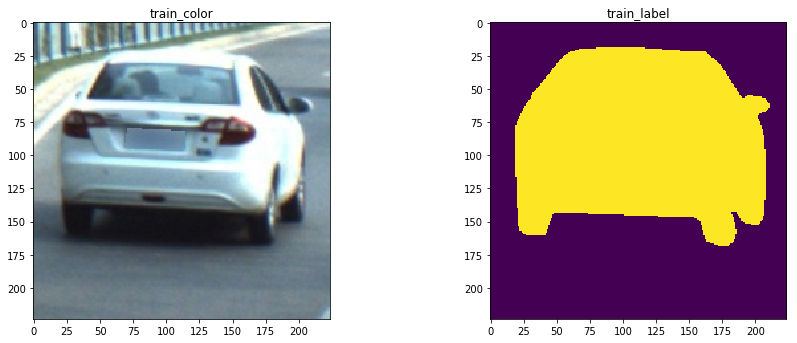

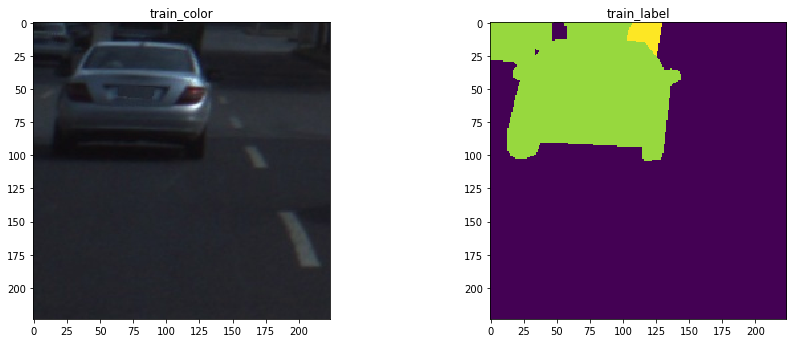

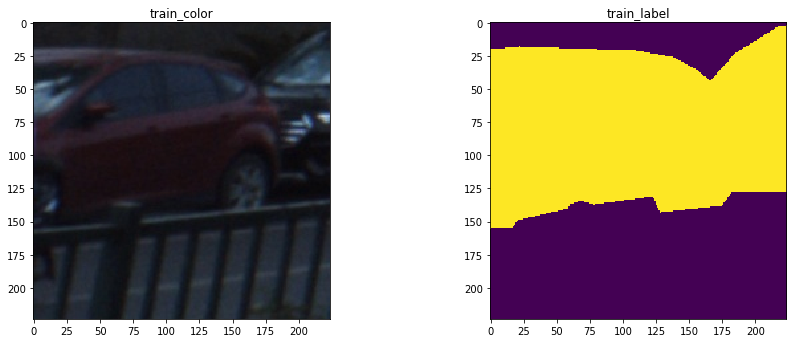

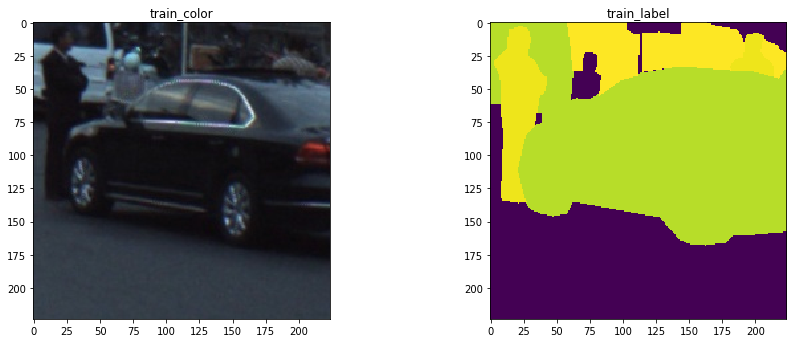

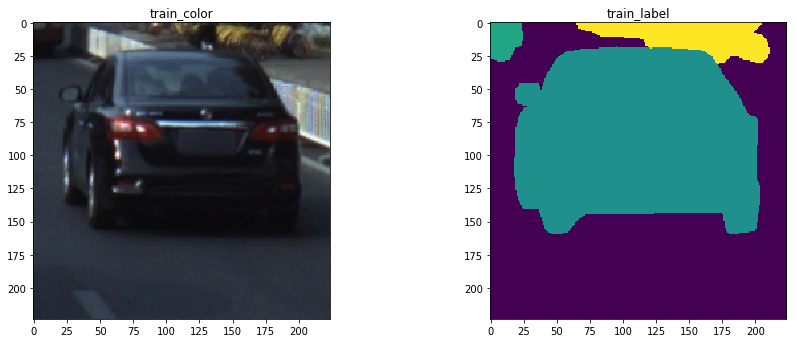

In [6]:
# number of images to plot
n = 5

# obtain "n" random indexes
indxs = np.arange(len(filelist_x))
indx = np.random.choice(indxs, n, replace = False)

for i in range(n):
    #print(filelist_x[indx[i]])
    file_x = np.array(cv2.imread(os.path.join(file_dir, file_dirs_color[3], filelist_x[indx[i]]), -1))/255
    file_y = np.array(cv2.imread(os.path.join(file_dir, file_dirs_label[3], filelist_y[indx[i]]), -1))
    plt.figure(figsize = (15,12))
    plt.subplot(2,2,1)
    plt.imshow(file_x); plt.title('train_color')
    plt.subplot(2,2,2)
    plt.imshow(file_y); plt.title('train_label')
plt.show()

(224, 224, 3)


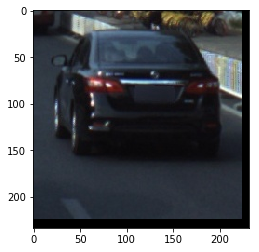

In [7]:
print(file_x.shape)
b = np.pad(file_x,((0,10),(0,8),(0,0)), 'constant', constant_values = 0)
plt.imshow(b)
plt.show()

## Split dataset

Once its tested that the images can be loaded, the dataset will be splitted into training and validation. Only the list of filenames will be splitted.

In [8]:
# split the dataset (filenames)
# x_train, x_val, y_train, y_val = train_test_split(filelist_x,
#                                                   filelist_y,
#                                                   test_size = 0.1,
#                                                   random_state = seed)

## PatchGenerator

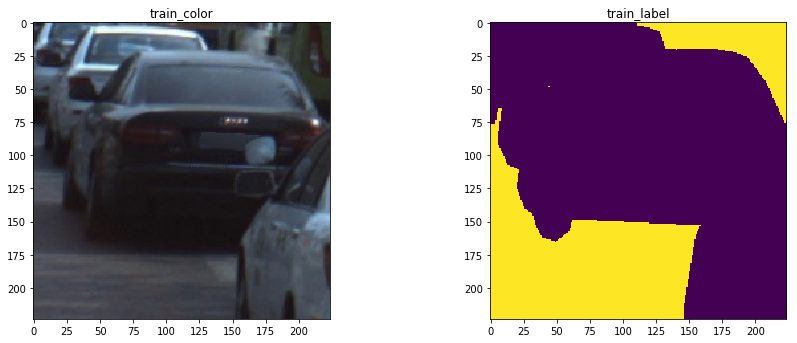

In [9]:
# test the data generator
training_gen = PatchGenerator(
    input_dir       = file_dir, 
    class_labels    = class_labels,
    batch_size      = 8,
    batches         = [32, 128, 224, 416, 1024]
)

for batch_x, batch_y in training_gen:
    # plot first sample
    plt.figure(figsize = (15,12))
    plt.subplot(2,2,1)
    plt.imshow(batch_x[0]); plt.title('train_color')
    plt.subplot(2,2,2)
    plt.imshow(np.argmax(batch_y[0], axis=-1)); plt.title('train_label')
    plt.show()
    break

## Network Training

In [10]:
# since we are going to segment the image, the input should not have any dimension
x_in = Input(shape=(None, None, 3))

vgg_16_new = createVGGskip_2(x_in)
vgg_16_new = multi_gpu_model(vgg_16_new, gpus = 2)

/home/pabloleo96/MLiP2/create_model.py:201: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  vgg_16_new = Model(input = in_t, output = x_out)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [11]:
training_data = PatchGenerator(
    input_dir       = file_dir, 
    class_labels    = class_labels,
    batch_size      = 40,
    batches         = [128, 224, 416]
)

print(training_data.percentages)
print(int(training_data.totalLength//training_data.batch_size))

# compile variables
learning_rate = 1e-3 # learning rate
optimizer = Adam(learning_rate) # optimizer
loss_func = 'categorical_crossentropy'
metrics = ['accuracy']

# compile and return the model
vgg_16_new.compile(optimizer, loss_func, metrics)

[0.7907601213741736, 0.1332447721963446, 0.07599510642948178]
8807


In [12]:
# model name
model_name = 'best_model_unet-only_cars.h5'
#model_name = 'best_model_vgg_8c-tests.h5'

In [13]:
# checkpoint to store the best model
checkpoint = ModelCheckpoint(os.path.join(result_dir, model_name),
                             monitor = 'acc', 
                             verbose = 1, 
                             save_best_only = True,
                             save_weights_only = True,
                             mode = 'max', 
                             period = 1)

# stop the model when it doesnt increase the acc
earlystopping = EarlyStopping(monitor = 'acc', 
                              min_delta = 0.03, 
                              patience = 6,
                              verbose = 1, 
                              mode = 'max')

# print results to file
printdata = PrintData()

/home/pabloleo96/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/500
100/100 [==============================] - 90s 898ms/step - loss: 0.5137 - acc: 0.6661

Epoch 00001: acc improved from -inf to 0.66612, saving model to ./results/best_model_unet-only_cars.h5


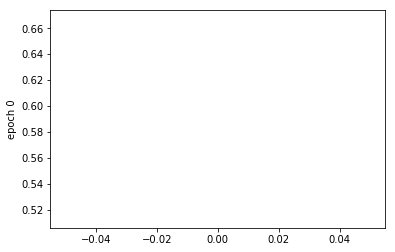

Epoch 2/500
100/100 [==============================] - 77s 772ms/step - loss: 0.4362 - acc: 0.7307

Epoch 00002: acc improved from 0.66612 to 0.73067, saving model to ./results/best_model_unet-only_cars.h5


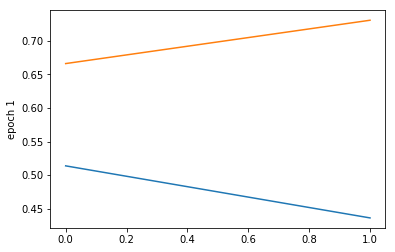

Epoch 3/500
100/100 [==============================] - 80s 795ms/step - loss: 0.4102 - acc: 0.7428

Epoch 00003: acc improved from 0.73067 to 0.74282, saving model to ./results/best_model_unet-only_cars.h5


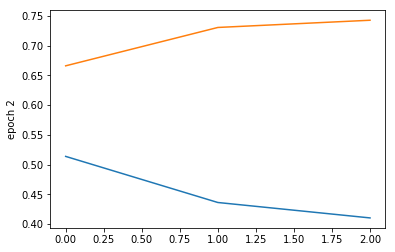

Epoch 4/500
100/100 [==============================] - 68s 682ms/step - loss: 0.3907 - acc: 0.7535

Epoch 00004: acc improved from 0.74282 to 0.75353, saving model to ./results/best_model_unet-only_cars.h5


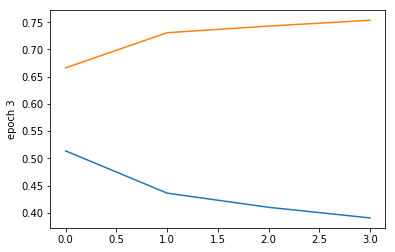

Epoch 5/500
 58/100 [================>.............] - ETA: 28s - loss: 0.3722 - acc: 0.7638

In [ ]:
history = vgg_16_new.fit_generator(training_data,
                                   steps_per_epoch = 100,#int(training_data.totalLength//training_data.batch_size),
                                   epochs = 500,
                                   callbacks = [checkpoint, printdata],
                                   use_multiprocessing = True,
                                   workers = 2
                                   )

In [ ]:
import subprocess
if False:
    print(subprocess.check_output(['sudo', 'shutdown', 'now']))

In [ ]:
# obtain a list of files in the given directory
# file_dir_or = './data/king-fish-bucket'
# filelist_x_or = np.array(sorted(os.listdir(os.path.join(file_dir_or, 'train_color'))))
# filelist_y_or = np.array(sorted(os.listdir(os.path.join(file_dir_or, 'train_label'))))


file_dir_or = './data/full_data'
filelist_x_or = np.array(sorted(os.listdir(os.path.join(file_dir_or, 'train_color'))))
filelist_y_or = np.array(sorted(os.listdir(os.path.join(file_dir_or, 'train_label'))))

n = 10

file_x_original = []
file_y_original = []
for i in range(n):
    file_x_original.append(np.pad(np.array(cv2.imread(os.path.join(file_dir_or, 'train_color', filelist_x_or[500+i]), -1))/255,((0,10),(0,8),(0,0)), 'constant', constant_values = 0))
    file_y_original.append(np.pad(np.array(cv2.imread(os.path.join(file_dir_or, 'train_label', filelist_y_or[500+i]), -1)),((0,10),(0,8)), 'constant', constant_values = 0))

file_x_original = np.array(file_x_original)
file_y_original = np.array(file_y_original)
file_y_pred = history.model.predict(file_x_original[:,1500:2012,0:2048,:], batch_size=1)

#file_y_pred[file_y_pred > 0.4] = 1
#file_y_pred[file_y_pred < 0.4] = 0

for i in range(n):
    plt.figure(figsize = (15,12))
    plt.subplot(2,3,1)
    plt.imshow(file_x_original[i,1500:2012,0:2048,:]); plt.title('original_color')
    plt.subplot(2,3,2)
    plt.imshow(file_y_original[i,1500:2012,0:2048]); plt.title('original_label')
    plt.subplot(2,3,3)
    plt.imshow(np.argmax(file_y_pred[i], axis=-1)); plt.title('predicted_label')
plt.show()